# Topological Characterization: Connected Component Analysis

**Laser-focused investigation of the topology of the token cluster**

This notebook performs a complete topological decomposition of the token embedding space at a given snapshot:

1. **Component census:** Full list of all connected components
2. **Component properties:** Size, centroid, internal distances
3. **Inter-component distances:** How far apart are different components?
4. **Dead/live membership:** Which tokens are in which components?

## The Key Question

Is training causing the primordial atom to **sublimate** (tokens escaping one-by-one) or **fragment** (breaking into multiple clusters)?

We look for:
- **Main component:** The primordial atom (should contain dead tokens)
- **Small components:** Escapees still traveling together (2-5 tokens)
- **Singletons:** Solo escapees flying free

## Parameters

In [51]:
# Data source
# DATA_SOURCE = 'training_snapshot'  # or 'embedding_matrix'
# TRAINING_DATA_PATH = '../tensors/Lil_Gatsby/1.9c_training_data.safetensors'
# SNAPSHOT_STEP = 1000
# RUN_NAME = '1.9c at step 1000 (Adam, lr=1e-3)'

# Alternative: standalone embedding matrix
DATA_SOURCE = 'embedding_matrix'
EMBEDDING_PATH = '../tensors/Qwen3-4B-Instruct-2507/W.safetensors'
RUN_NAME = 'Qwen 3 4B Instruct'

# Connectivity threshold
DISTANCE_THRESHOLD = 0.01  # Tokens within this distance are "connected"

# Visualization
DPI = 100

## Imports

In [52]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

## Load Data

In [53]:
print(f'Loading: {RUN_NAME}')
print()

if DATA_SOURCE == 'training_snapshot':
    data = load_file(TRAINING_DATA_PATH)
    W = data['embeddings'][SNAPSHOT_STEP].cpu().numpy()
    DEAD_TOKENS = data['dead_token_ids'].cpu().numpy() if 'dead_token_ids' in data else None
    LIVE_TOKENS = data['live_token_ids'].cpu().numpy() if 'live_token_ids' in data else None
elif DATA_SOURCE == 'embedding_matrix':
    data = load_file(EMBEDDING_PATH)
    W = data['W'].cpu().numpy() if 'W' in data else data['embeddings'].cpu().numpy()
    DEAD_TOKENS = data['dead_token_ids'].cpu().numpy() if 'dead_token_ids' in data else None
    LIVE_TOKENS = data['live_token_ids'].cpu().numpy() if 'live_token_ids' in data else None

n_tokens = W.shape[0]
embedding_dim = W.shape[1]

print(f'Embeddings: {W.shape}')
if DEAD_TOKENS is not None:
    print(f'Dead tokens: {len(DEAD_TOKENS)}')
if LIVE_TOKENS is not None:
    print(f'Live tokens: {len(LIVE_TOKENS)}')
print()

Loading: Qwen 3 4B Instruct



TypeError: Got unsupported ScalarType BFloat16

## Build Connectivity Graph

In [ ]:
print(f'Building connectivity graph (threshold = {DISTANCE_THRESHOLD})...')
print()

# Pairwise distances
distances_condensed = pdist(W, metric='euclidean')
distances_matrix = squareform(distances_condensed)

# Adjacency: tokens connected if distance < threshold
adjacency = (distances_matrix < DISTANCE_THRESHOLD) & (distances_matrix > 0)

n_edges = adjacency.sum() // 2
print(f'✓ Built adjacency graph')
print(f'  Edges: {n_edges}')
print(f'  Mean degree: {adjacency.sum(axis=1).mean():.2f}')
print()

Building connectivity graph (threshold = 0.01)...

✓ Built adjacency graph
  Edges: 1329
  Mean degree: 20.77



## Find Connected Components

In [ ]:
print('Finding connected components (BFS)...')
print()

visited = np.zeros(n_tokens, dtype=bool)
components = []

for start in range(n_tokens):
    if visited[start]:
        continue
    
    # BFS from start
    component = []
    queue = [start]
    visited[start] = True
    
    while queue:
        node = queue.pop(0)
        component.append(node)
        
        # Add unvisited neighbors
        neighbors = np.where(adjacency[node])[0]
        for neighbor in neighbors:
            if not visited[neighbor]:
                visited[neighbor] = True
                queue.append(neighbor)
    
    components.append(component)

# Sort by size (largest first)
components = sorted(components, key=len, reverse=True)

print(f'✓ Found {len(components)} connected components')
print(f'  Largest: {len(components[0])} tokens')
if len(components) > 1:
    print(f'  Second: {len(components[1])} tokens')
print(f'  Singletons: {sum(1 for c in components if len(c) == 1)}')
print()

Finding connected components (BFS)...

✓ Found 71 connected components
  Largest: 56 tokens
  Second: 3 tokens
  Singletons: 69



## Component Properties

In [ ]:
print('Computing component properties...')
print()

# Separate singletons from non-singletons
non_singleton_components = [c for c in components if len(c) > 1]
singleton_indices = [c[0] for c in components if len(c) == 1]

# Store component info
component_info = []

for i, comp in enumerate(non_singleton_components):
    comp_embeddings = W[comp]
    
    # Centroid
    centroid = comp_embeddings.mean(axis=0)
    centroid_norm = np.linalg.norm(centroid)
    
    # Intra-component distances
    if len(comp) > 1:
        intra_distances = pdist(comp_embeddings)
        intra_mean = intra_distances.mean()
        intra_min = intra_distances.min()
        intra_max = intra_distances.max()
    else:
        intra_mean = intra_min = intra_max = 0.0
    
    # Dead/live membership
    if DEAD_TOKENS is not None and LIVE_TOKENS is not None:
        n_dead = sum(1 for tok in comp if tok in DEAD_TOKENS)
        n_live = sum(1 for tok in comp if tok in LIVE_TOKENS)
    else:
        n_dead = n_live = None
    
    component_info.append({
        'index': i,
        'size': len(comp),
        'members': comp,
        'centroid': centroid,
        'centroid_norm': centroid_norm,
        'intra_mean': intra_mean,
        'intra_min': intra_min,
        'intra_max': intra_max,
        'n_dead': n_dead,
        'n_live': n_live,
    })

# Singleton aggregate info
if singleton_indices:
    singleton_embeddings = W[singleton_indices]
    singleton_centroid = singleton_embeddings.mean(axis=0)
    singleton_centroid_norm = np.linalg.norm(singleton_centroid)
    singleton_norms = np.linalg.norm(singleton_embeddings, axis=1)
    
    # Pairwise distances between singletons
    if len(singleton_indices) > 1:
        singleton_pairwise = pdist(singleton_embeddings)
        singleton_pairwise_mean = singleton_pairwise.mean()
        singleton_pairwise_min = singleton_pairwise.min()
        singleton_pairwise_max = singleton_pairwise.max()
    else:
        singleton_pairwise_mean = singleton_pairwise_min = singleton_pairwise_max = 0.0
    
    # Dead/live membership
    if DEAD_TOKENS is not None and LIVE_TOKENS is not None:
        singleton_n_dead = sum(1 for tok in singleton_indices if tok in DEAD_TOKENS)
        singleton_n_live = sum(1 for tok in singleton_indices if tok in LIVE_TOKENS)
    else:
        singleton_n_dead = singleton_n_live = None
else:
    singleton_centroid = None
    singleton_centroid_norm = 0.0
    singleton_pairwise_mean = singleton_pairwise_min = singleton_pairwise_max = 0.0
    singleton_n_dead = singleton_n_live = None

print(f'✓ Computed properties for {len(component_info)} non-singleton components')
if singleton_indices:
    print(f'✓ Aggregated {len(singleton_indices)} singletons')
print()

Computing component properties...

✓ Computed properties for 2 non-singleton components
✓ Aggregated 69 singletons



## Component Census

In [ ]:
print('='*70)
print('COMPONENT CENSUS')
print('='*70)
print()
print(f'Threshold: {DISTANCE_THRESHOLD}')
print(f'Total components: {len(components)}')
print()

# Non-singleton components
for info in component_info:
    print(f"Component #{info['index']} ({info['size']} tokens):")
    print(f"  Centroid norm: {info['centroid_norm']:.6f}")
    print(f"  Intra-component distances:")
    print(f"    Mean: {info['intra_mean']:.6f}")
    print(f"    Range: [{info['intra_min']:.6f}, {info['intra_max']:.6f}]")
    
    if info['n_dead'] is not None:
        print(f"  Membership: {info['n_dead']} dead, {info['n_live']} live")
    
    # Show first 10 member IDs (convert to plain ints)
    members_preview = [int(m) for m in info['members'][:10]]
    if len(info['members']) > 10:
        print(f"  Members (first 10): {members_preview} ... ({info['size']} total)")
    else:
        members_list = [int(m) for m in info['members']]
        print(f"  Members: {members_list}")
    print()

# Singletons (aggregated)
if singleton_indices:
    print(f'Singletons ({len(singleton_indices)} tokens, aggregated):')
    print(f'  Centroid norm: {singleton_centroid_norm:.6f}')
    print(f'  Mean norm: {singleton_norms.mean():.6f}')
    print(f'  Pairwise distances (between singletons):')
    print(f'    Mean: {singleton_pairwise_mean:.6f}')
    print(f'    Range: [{singleton_pairwise_min:.6f}, {singleton_pairwise_max:.6f}]')
    
    if singleton_n_dead is not None:
        print(f'  Membership: {singleton_n_dead} dead, {singleton_n_live} live')
    
    # Show first 10 singleton IDs (convert to plain ints)
    singletons_preview = [int(s) for s in singleton_indices[:10]]
    if len(singleton_indices) > 10:
        print(f'  IDs (first 10): {singletons_preview} ... ({len(singleton_indices)} total)')
    else:
        singletons_list = [int(s) for s in singleton_indices]
        print(f'  IDs: {singletons_list}')

print('='*70)

COMPONENT CENSUS

Threshold: 0.01
Total components: 71

Component #0 (56 tokens):
  Centroid norm: 0.809963
  Intra-component distances:
    Mean: 0.000889
    Range: [0.000000, 0.005353]
  Membership: 50 dead, 6 live
  Members (first 10): [0, 1, 3, 7, 8, 9, 11, 12, 13, 15] ... (56 total)

Component #1 (3 tokens):
  Centroid norm: 0.808818
  Intra-component distances:
    Mean: 0.001819
    Range: [0.001614, 0.001980]
  Membership: 0 dead, 3 live
  Members: [51, 91, 93]

Singletons (69 tokens, aggregated):
  Centroid norm: 0.927845
  Mean norm: 0.955038
  Pairwise distances (between singletons):
    Mean: 0.324043
    Range: [0.011318, 0.905945]
  Membership: 0 dead, 69 live
  IDs (first 10): [10, 32, 33, 36, 40, 41, 42, 44, 45, 46] ... (69 total)


## Inter-Component Distances

In [ ]:
print('='*70)
print('INTER-COMPONENT DISTANCES')
print('='*70)
print()

# Build list of all centroids (including singleton aggregate)
centroids = [info['centroid'] for info in component_info]
centroid_labels = [f"Comp{info['index']} ({info['size']} tok)" for info in component_info]

if singleton_centroid is not None:
    centroids.append(singleton_centroid)
    centroid_labels.append(f'Singletons ({len(singleton_indices)} tok)')

# Compute pairwise distances between centroids
if len(centroids) > 1:
    centroid_distances = squareform(pdist(np.array(centroids)))
    
    print('Centroid-to-centroid distance matrix:')
    print()
    
    # Print header
    header = '        '
    for i, label in enumerate(centroid_labels):
        header += f'{i:>8}  '
    print(header)
    print('-' * len(header))
    
    # Print rows
    for i, label in enumerate(centroid_labels):
        row = f'{i:2} {label[:20]:<20}  '
        for j in range(len(centroid_labels)):
            if i == j:
                row += '    -     '
            else:
                row += f'{centroid_distances[i, j]:>8.4f}  '
        print(row)
    print()
else:
    print('Only one component (or all singletons), no inter-component distances.')
    print()

print('='*70)

INTER-COMPONENT DISTANCES

Centroid-to-centroid distance matrix:

               0         1         2  
--------------------------------------
 0 Comp0 (56 tok)            -       0.0296    0.4153  
 1 Comp1 (3 tok)           0.0296      -       0.3938  
 2 Singletons (69 tok)     0.4153    0.3938      -     



## Nearest-Neighbor Across Components

In [ ]:
print('='*70)
print('NEAREST-NEIGHBOR ACROSS COMPONENTS')
print('='*70)
print()

if len(centroids) > 1:
    for i, info in enumerate(component_info):
        # Find nearest other component (by centroid distance)
        dists_to_others = centroid_distances[i, :]
        dists_to_others[i] = np.inf  # Exclude self
        nearest_idx = dists_to_others.argmin()
        nearest_dist = dists_to_others[nearest_idx]
        
        print(f"Component {info['index']} ({info['size']} tokens):")
        print(f"  Nearest: {centroid_labels[nearest_idx]}")
        print(f"  Distance: {nearest_dist:.6f}")
        print()
    
    # Singletons: find nearest non-singleton component
    if singleton_centroid is not None:
        singleton_idx = len(component_info)  # Index of singleton aggregate
        dists_to_others = centroid_distances[singleton_idx, :]
        dists_to_others[singleton_idx] = np.inf
        nearest_idx = dists_to_others.argmin()
        nearest_dist = dists_to_others[nearest_idx]
        
        print(f'Singletons ({len(singleton_indices)} tokens, aggregate centroid):')
        print(f'  Nearest: {centroid_labels[nearest_idx]}')
        print(f'  Distance: {nearest_dist:.6f}')
        print()
        
        # Also find minimum actual distance from any singleton to any non-singleton component
        min_actual_dist = np.inf
        for singleton_tok in singleton_indices:
            for info in component_info:
                for comp_tok in info['members']:
                    dist = distances_matrix[singleton_tok, comp_tok]
                    if dist < min_actual_dist:
                        min_actual_dist = dist
                        closest_singleton = singleton_tok
                        closest_comp_idx = info['index']
        
        print(f'  Minimum actual distance (any singleton to any non-singleton component):')
        print(f'    Token {closest_singleton} → Component {closest_comp_idx}: {min_actual_dist:.6f}')
else:
    print('Only one component, no nearest-neighbor analysis.')

print('='*70)

NEAREST-NEIGHBOR ACROSS COMPONENTS

Component 0 (56 tokens):
  Nearest: Comp1 (3 tok)
  Distance: 0.029635

Component 1 (3 tokens):
  Nearest: Comp0 (56 tok)
  Distance: 0.029635

Singletons (69 tokens, aggregate centroid):
  Nearest: Comp1 (3 tok)
  Distance: 0.393759

  Minimum actual distance (any singleton to any non-singleton component):
    Token 50 → Component 1: 0.016096


## Visualization: Component Size Distribution

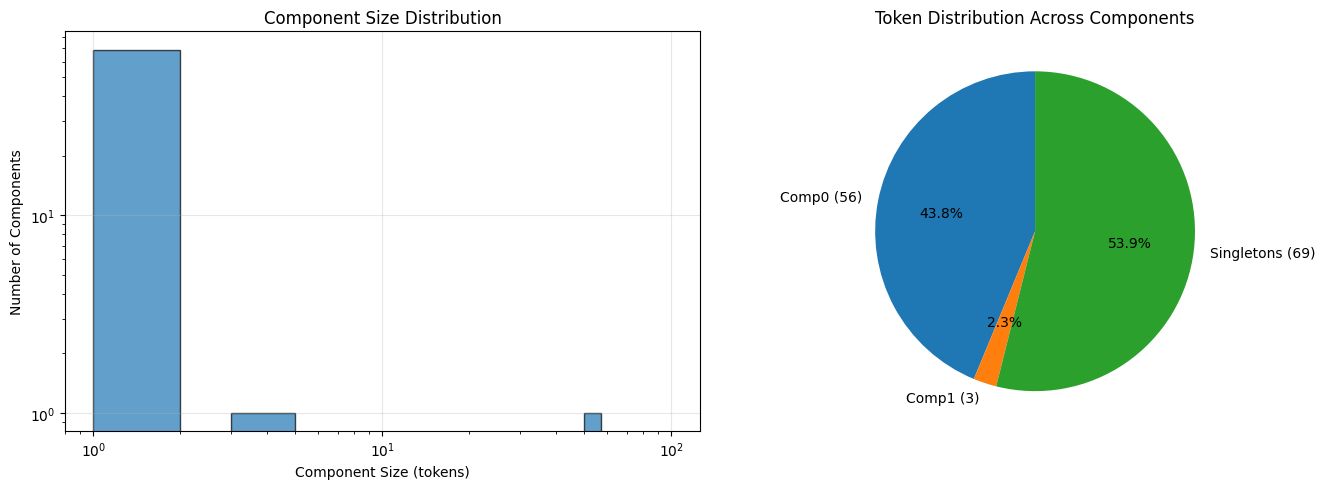

In [ ]:
component_sizes = [len(c) for c in components]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Left: Component size histogram (log scale)
ax = axes[0]

# Create bins that don't exceed max component size
max_size = max(component_sizes)
bins = [1, 2, 3, 5, 10, 20, 50]
if max_size > 50:
    bins.append(100)
if max_size > 100:
    bins.append(max_size + 1)
else:
    bins.append(max_size + 1)

# Remove duplicates and sort
bins = sorted(list(set(bins)))

ax.hist(component_sizes, bins=bins, edgecolor='black', alpha=0.7)
ax.set_xlabel('Component Size (tokens)')
ax.set_ylabel('Number of Components')
ax.set_title('Component Size Distribution')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(alpha=0.3)

# Right: Pie chart of token allocation
ax = axes[1]
labels = []
sizes = []

for info in component_info[:5]:  # Top 5 non-singleton components
    labels.append(f"Comp{info['index']} ({info['size']})")
    sizes.append(info['size'])

if len(component_info) > 5:
    other_size = sum(info['size'] for info in component_info[5:])
    labels.append(f'Other ({other_size})')
    sizes.append(other_size)

if singleton_indices:
    labels.append(f'Singletons ({len(singleton_indices)})')
    sizes.append(len(singleton_indices))

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Token Distribution Across Components')

plt.tight_layout()
plt.show()

## Summary Report

In [ ]:
print('\n')
print('='*70)
print('TOPOLOGICAL CHARACTERIZATION SUMMARY')
print('='*70)
print()
print(f'Dataset: {RUN_NAME}')
print(f'Threshold: {DISTANCE_THRESHOLD}')
print()

print('TOPOLOGY:')
print(f'  Total components: {len(components)}')
print(f'  Largest component: {len(components[0])} tokens')
if len(components) > 1:
    print(f'  Second largest: {len(components[1])} tokens')
print(f'  Singletons: {len(singleton_indices)}')
print()

if component_info:
    print('MAIN COMPONENT (largest):')
    main = component_info[0]
    print(f'  Size: {main["size"]} tokens')
    print(f'  Intra-distance: {main["intra_mean"]:.6f}')
    if main['n_dead'] is not None:
        print(f'  Composition: {main["n_dead"]} dead, {main["n_live"]} live')
    print()

if singleton_indices:
    print('SINGLETONS:')
    print(f'  Count: {len(singleton_indices)}')
    print(f'  Mean pairwise distance: {singleton_pairwise_mean:.6f}')
    if singleton_n_dead is not None:
        print(f'  Composition: {singleton_n_dead} dead, {singleton_n_live} live')
    print()

# Interpretation
print('INTERPRETATION:')
if len(components[0]) > 0.5 * n_tokens:
    print('  → PRIMORDIAL ATOM: Most tokens still in main cluster')
elif len(singleton_indices) > 0.5 * n_tokens:
    print('  → DISPERSED CLOUD: Most tokens flying solo')
else:
    print('  → FRAGMENTED: Multiple significant components')

if DEAD_TOKENS is not None and component_info:
    main_dead_fraction = main['n_dead'] / len(DEAD_TOKENS) if main['n_dead'] else 0
    if main_dead_fraction > 0.9:
        print('  → DEAD TOKENS TRAPPED: >90% in main component')

print('='*70)



TOPOLOGICAL CHARACTERIZATION SUMMARY

Dataset: 1.9c at step 1000 (Adam, lr=1e-3)
Threshold: 0.01

TOPOLOGY:
  Total components: 71
  Largest component: 56 tokens
  Second largest: 3 tokens
  Singletons: 69

MAIN COMPONENT (largest):
  Size: 56 tokens
  Intra-distance: 0.000889
  Composition: 50 dead, 6 live

SINGLETONS:
  Count: 69
  Mean pairwise distance: 0.324043
  Composition: 0 dead, 69 live

INTERPRETATION:
  → DISPERSED CLOUD: Most tokens flying solo
  → DEAD TOKENS TRAPPED: >90% in main component
